In [ ]:
!unzip image_and_mask.zip

Streaming output truncated to the last 5000 lines.
  inflating: image_and_mask/Mask/000000047940.png  
  inflating: image_and_mask/Mask/000000232383.png  
  inflating: image_and_mask/Mask/000000457754.png  
  inflating: image_and_mask/Mask/000000056865.png  
  inflating: image_and_mask/Mask/000000268927.png  
  inflating: image_and_mask/Mask/000000414679.png  
  inflating: image_and_mask/Mask/000000028377.png  
  inflating: image_and_mask/Mask/000000127050.png  
  inflating: image_and_mask/Mask/000000503311.png  
  inflating: image_and_mask/Mask/000000161011.png  
  inflating: image_and_mask/Mask/000000170849.png  
  inflating: image_and_mask/Mask/000000520251.png  
  inflating: image_and_mask/Mask/000000239229.png  
  inflating: image_and_mask/Mask/000000144534.png  
  inflating: image_and_mask/Mask/000000560675.png  
  inflating: image_and_mask/Mask/000000009420.png  
  inflating: image_and_mask/Mask/000000139291.png  
  inflating: image_and_mask/Mask/000000407822.png  
  inflating: 

In [1]:
img_dir = "/Users/spoorthivattem/Desktop/Roads/Image_and_masks/Image"
mask_dir  = "/Users/spoorthivattem/Desktop/Roads/Image_and_masks/Mask"

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

In [3]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True)
        )

    def forward(self, x):
        return self.conv_op(x)

class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)

    def forward(self,x):
        down = self.conv(x)
        p = self.pool(down)
        return down, p

class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride = 2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x1, x2], 1)
        return self.conv(x)

In [4]:
class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.down_convolution_1 = DownSample(in_channels, 64)
        self.down_convolution_2 = DownSample(64, 128)
        self.down_convolution_3 = DownSample(128, 256)
        self.down_convolution_4 = DownSample(256, 512)

        self.bottle_neck = DoubleConv(512, 1024)

        self.up_convolution_1 = UpSample(1024, 512)
        self.up_convolution_2 = UpSample(512, 256)
        self.up_convolution_3 = UpSample(256, 128)
        self.up_convolution_4 = UpSample(128, 64)

        self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
        down_1, p1 = self.down_convolution_1(x)
        down_2, p2 = self.down_convolution_2(p1)
        down_3, p3 = self.down_convolution_3(p2)
        down_4, p4 = self.down_convolution_4(p3)

        b = self.bottle_neck(p4)

        up_1 = self.up_convolution_1(b, down_4)
        up_2 = self.up_convolution_2(up_1, down_3)
        up_3 = self.up_convolution_3(up_2, down_2)
        up_4 = self.up_convolution_4(up_3, down_1)

        out = self.out(up_4)
        return out

In [5]:
class Image_Dataset(Dataset):
    def __init__(self, root_path, test=False):
        self.root_path = root_path

        if test:
            self.images = sorted([
                os.path.join(root_path, "test_images", i)
                for i in os.listdir(os.path.join(root_path, "test_images"))
            ])
            self.masks = sorted([
                os.path.join(root_path, "test_masks", i)
                for i in os.listdir(os.path.join(root_path, "test_masks"))
            ])
        else:
            self.images = sorted([
                os.path.join(root_path, "Image", i)
                for i in os.listdir(os.path.join(root_path, "Image"))
            ])
            self.masks = sorted([
                os.path.join(root_path, "Mask", i)
                for i in os.listdir(os.path.join(root_path, "Mask"))
            ])

        self.transform = transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.ToTensor()
        ])

    def __getitem__(self, index):
        img = Image.open(self.images[index]).convert("RGB")
        mask = Image.open(self.masks[index]).convert("L")  # grayscale for mask
        return self.transform(img), self.transform(mask)

    def __len__(self):
        return len(self.images)


✅ Using Apple Silicon GPU via MPS
Checking mask values...
Mask check complete. Bad masks: 0


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:53<00:00,  2.63s/it]
                                                                                                                                                                                                                
Epochs:   5%|████████▏                                                                                                                                                           | 1/20 [00:58<18:39, 58.90s/it]

--------------------------------------------------
Epoch 1/20
Train Loss: 0.6529
Val Loss: 0.5162
--------------------------------------------------
✅ Model saved at: /Users/spoorthivattem/Desktop/checkpoints/unet_epoch_1.pth



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:06<00:00,  3.28s/it]
                                                                                                                                                                                                                
Epochs:  10%|████████████████▍                                                                                                                                                   | 2/20 [02:11<20:07, 67.08s/it]

--------------------------------------------------
Epoch 2/20
Train Loss: 0.4879
Val Loss: 0.4541
--------------------------------------------------
✅ Model saved at: /Users/spoorthivattem/Desktop/checkpoints/unet_epoch_2.pth



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:05<00:00,  2.95s/it]
                                                                                                                                                                                                                
Epochs:  15%|████████████████████████▌                                                                                                                                           | 3/20 [03:22<19:32, 68.97s/it]

--------------------------------------------------
Epoch 3/20
Train Loss: 0.4705
Val Loss: 0.4471
--------------------------------------------------
✅ Model saved at: /Users/spoorthivattem/Desktop/checkpoints/unet_epoch_3.pth



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:05<00:00,  3.05s/it]
                                                                                                                                                                                                                
Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.09s/it]
                                                                                                                                                                                                                

--------------------------------------------------
Epoch 4/20
Train Loss: 0.4452
Val Loss: 0.4391
--------------------------------------------------


Epochs:  20%|████████████████████████████████▊                                                                                                                                   | 4/20 [04:34<18:37, 69.85s/it]

✅ Model saved at: /Users/spoorthivattem/Desktop/checkpoints/unet_epoch_4.pth



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:09<00:00,  3.22s/it]
                                                                                                                                                                                                                
Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.11s/it]
                                                                                                                                                                                                                

--------------------------------------------------
Epoch 5/20
Train Loss: 0.4367
Val Loss: 0.4256
--------------------------------------------------


Epochs:  25%|█████████████████████████████████████████                                                                                                                           | 5/20 [05:49<17:57, 71.81s/it]

✅ Model saved at: /Users/spoorthivattem/Desktop/checkpoints/unet_epoch_5.pth



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:07<00:00,  3.16s/it]
                                                                                                                                                                                                                
Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.08s/it]
                                                                                                                                                                                                                

--------------------------------------------------
Epoch 6/20
Train Loss: 0.4265
Val Loss: 0.4087
--------------------------------------------------


Epochs:  30%|█████████████████████████████████████████████████▏                                                                                                                  | 6/20 [07:03<16:54, 72.43s/it]

✅ Model saved at: /Users/spoorthivattem/Desktop/checkpoints/unet_epoch_6.pth



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:08<00:00,  3.15s/it]
                                                                                                                                                                                                                
Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.12s/it]
                                                                                                                                                                                                                

--------------------------------------------------
Epoch 7/20
Train Loss: 0.4084
Val Loss: 0.3901
--------------------------------------------------


Epochs:  35%|█████████████████████████████████████████████████████████▍                                                                                                          | 7/20 [08:17<15:50, 73.15s/it]

✅ Model saved at: /Users/spoorthivattem/Desktop/checkpoints/unet_epoch_7.pth



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:08<00:00,  3.26s/it]
                                                                                                                                                                                                                
Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.14s/it]
                                                                                                                                                                                                                

--------------------------------------------------
Epoch 8/20
Train Loss: 0.3929
Val Loss: 0.3824
--------------------------------------------------


Epochs:  40%|█████████████████████████████████████████████████████████████████▌                                                                                                  | 8/20 [09:32<14:43, 73.60s/it]

✅ Model saved at: /Users/spoorthivattem/Desktop/checkpoints/unet_epoch_8.pth



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:08<00:00,  3.21s/it]
                                                                                                                                                                                                                
Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.11s/it]
                                                                                                                                                                                                                

--------------------------------------------------
Epoch 9/20
Train Loss: 0.3753
Val Loss: 0.3792
--------------------------------------------------


Epochs:  45%|█████████████████████████████████████████████████████████████████████████▊                                                                                          | 9/20 [10:46<13:32, 73.83s/it]

✅ Model saved at: /Users/spoorthivattem/Desktop/checkpoints/unet_epoch_9.pth



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:08<00:00,  3.20s/it]
                                                                                                                                                                                                                
Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.12s/it]
                                                                                                                                                                                                                

--------------------------------------------------
Epoch 10/20
Train Loss: 0.3725
Val Loss: 0.3595
--------------------------------------------------


Epochs:  50%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 10/20 [12:01<12:21, 74.20s/it]

✅ Model saved at: /Users/spoorthivattem/Desktop/checkpoints/unet_epoch_10.pth



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:07<00:00,  3.13s/it]
                                                                                                                                                                                                                
Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.04s/it]
                                                                                                                                                                                                                

--------------------------------------------------
Epoch 11/20
Train Loss: 0.3745
Val Loss: 0.3592
--------------------------------------------------


Epochs:  55%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 11/20 [13:14<11:05, 73.94s/it]

✅ Model saved at: /Users/spoorthivattem/Desktop/checkpoints/unet_epoch_11.pth



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:59<00:00,  2.76s/it]
                                                                                                                                                                                                                
Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.02it/s]
                                                                                                                                                                                                                

--------------------------------------------------
Epoch 12/20
Train Loss: 0.3568
Val Loss: 0.3593
--------------------------------------------------


Epochs:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 12/20 [14:19<09:29, 71.18s/it]

✅ Model saved at: /Users/spoorthivattem/Desktop/checkpoints/unet_epoch_12.pth



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:01<00:00,  3.02s/it]
                                                                                                                                                                                                                
Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.16s/it]
                                                                                                                                                                                                                

--------------------------------------------------
Epoch 13/20
Train Loss: 0.3582
Val Loss: 0.3530
--------------------------------------------------
✅ Model saved at: /Users/spoorthivattem/Desktop/checkpoints/unet_epoch_13.pth


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:02<00:00,  2.91s/it]
                                                                                                                                                                                                                
Epochs:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 14/20 [16:36<06:58, 69.71s/it]

--------------------------------------------------
Epoch 14/20
Train Loss: 0.3551
Val Loss: 0.3791
--------------------------------------------------
✅ Model saved at: /Users/spoorthivattem/Desktop/checkpoints/unet_epoch_14.pth



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:02<00:00,  2.87s/it]
                                                                                                                                                                                                                
Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.02s/it]
                                                                                                                                                                                                                

--------------------------------------------------
Epoch 15/20
Train Loss: 0.3661
Val Loss: 0.3519
--------------------------------------------------


Epochs:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 15/20 [17:44<05:46, 69.37s/it]

✅ Model saved at: /Users/spoorthivattem/Desktop/checkpoints/unet_epoch_15.pth



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:01<00:00,  2.91s/it]
                                                                                                                                                                                                                
Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.02s/it]
                                                                                                                                                                                                                

--------------------------------------------------
Epoch 16/20
Train Loss: 0.3518
Val Loss: 0.3653
--------------------------------------------------


Epochs:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 16/20 [18:51<04:34, 68.62s/it]

✅ Model saved at: /Users/spoorthivattem/Desktop/checkpoints/unet_epoch_16.pth



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:59<00:00,  2.78s/it]
                                                                                                                                                                                                                
Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.01it/s]
                                                                                                                                                                                                                

--------------------------------------------------
Epoch 17/20
Train Loss: 0.3621
Val Loss: 0.3881
--------------------------------------------------


Epochs:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 17/20 [19:56<03:22, 67.44s/it]

✅ Model saved at: /Users/spoorthivattem/Desktop/checkpoints/unet_epoch_17.pth



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:00<00:00,  2.82s/it]
                                                                                                                                                                                                                
Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.03s/it]
                                                                                                                                                                                                                

--------------------------------------------------
Epoch 18/20
Train Loss: 0.3572
Val Loss: 0.3500
--------------------------------------------------


Epochs:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 18/20 [21:02<02:13, 66.98s/it]

✅ Model saved at: /Users/spoorthivattem/Desktop/checkpoints/unet_epoch_18.pth



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:00<00:00,  2.84s/it]
                                                                                                                                                                                                                
Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.05s/it]
                                                                                                                                                                                                                

--------------------------------------------------
Epoch 19/20
Train Loss: 0.3494
Val Loss: 0.3581
--------------------------------------------------


Epochs:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 19/20 [22:09<01:06, 66.90s/it]

✅ Model saved at: /Users/spoorthivattem/Desktop/checkpoints/unet_epoch_19.pth



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:01<00:00,  2.87s/it]
                                                                                                                                                                                                                
Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.02s/it]
                                                                                                                                                                                                                

--------------------------------------------------
Epoch 20/20
Train Loss: 0.3494
Val Loss: 0.3515
--------------------------------------------------


Epochs: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [23:15<00:00, 69.80s/it]

✅ Model saved at: /Users/spoorthivattem/Desktop/checkpoints/unet_epoch_20.pth


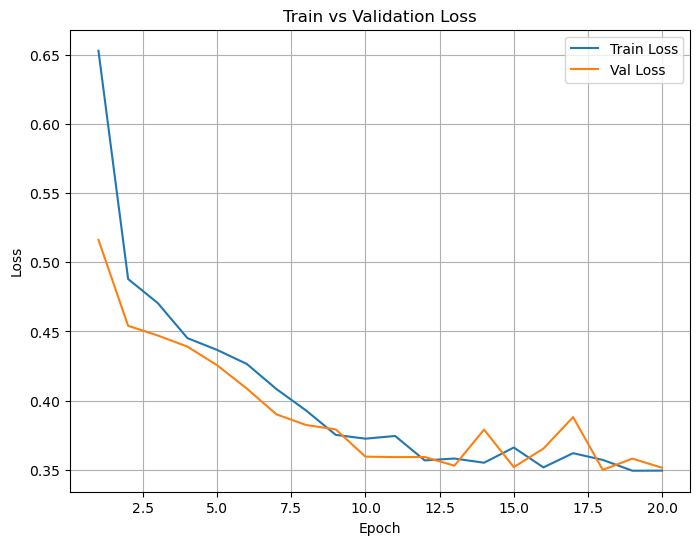

In [12]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
import torch.nn as nn
from PIL import Image
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

# -----------------------
# Main Training Script
# -----------------------
if __name__ == "__main__":
    LEARNING_RATE = 1e-4
    BATCH_SIZE = 4
    EPOCHS = 20
    DATA_PATH = "/Users/spoorthivattem/Desktop/Roads/Image_and_masks"
    MODEL_SAVE_DIR = "/Users/spoorthivattem/Desktop/checkpoints"

    # ✅ Create checkpoints folder if it doesn't exist
    os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

    # ✅ Device selection: Prefer MPS, else CUDA, else CPU
    if torch.backends.mps.is_available() and torch.backends.mps.is_built():
        device = torch.device("mps")
        print("✅ Using Apple Silicon GPU via MPS")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
        print("✅ Using NVIDIA GPU via CUDA")
    else:
        device = torch.device("cpu")
        print("⚠️ Using CPU (no GPU found)")

    # Load dataset
    full_dataset = Image_Dataset(DATA_PATH)
    dataset_length = len(full_dataset)
    if dataset_length == 0:
        raise ValueError("Dataset is empty. Check paths and files.")

    # Mask sanity check
    print("Checking mask values...")
    bad_masks = 0
    for i in range(min(20, len(full_dataset))):
        _, mask = full_dataset[i]
        if mask.max() > 1 or mask.min() < 0:
            bad_masks += 1
    print(f"Mask check complete. Bad masks: {bad_masks}")

    # Train/Val split
    generator = torch.Generator().manual_seed(42)
    train_size = int(0.8 * dataset_length)
    val_size = dataset_length - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size], generator=generator)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Initialize model, optimizer, loss
    model = UNet(in_channels=3, num_classes=1).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.BCEWithLogitsLoss()

    # Store loss history for plotting
    train_losses = []
    val_losses = []

    for epoch in tqdm(range(EPOCHS), desc="Epochs"):
        model.train()
        train_loss_sum = 0.0

        for batch_idx, (imgs, masks) in enumerate(tqdm(train_loader, leave=False, desc="Training")):
            imgs, masks = imgs.to(device), masks.to(device)
            optimizer.zero_grad()
            preds = model(imgs)

            # Safety check for NaNs
            if torch.isnan(preds).any() or torch.isnan(masks).any():
                print(f"NaN detected in batch {batch_idx}")
                continue

            loss = criterion(preds, masks)
            train_loss_sum += loss.item()
            loss.backward()
            optimizer.step()

        train_loss = train_loss_sum / (batch_idx + 1)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss_sum = 0.0
        with torch.no_grad():
            for batch_idx, (imgs, masks) in enumerate(tqdm(val_loader, leave=False, desc="Validation")):
                imgs, masks = imgs.to(device), masks.to(device)
                preds = model(imgs)
                loss = criterion(preds, masks)
                val_loss_sum += loss.item()
        val_loss = val_loss_sum / (batch_idx + 1)
        val_losses.append(val_loss)

        print("-" * 50)
        print(f"Epoch {epoch+1}/{EPOCHS}")
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val Loss: {val_loss:.4f}")
        print("-" * 50)

        # ✅ Save checkpoint for each epoch
        model_save_path = os.path.join(MODEL_SAVE_DIR, f"unet_epoch_{epoch+1}.pth")
        torch.save(model.state_dict(), model_save_path)
        print(f"✅ Model saved at: {model_save_path}")

    # ✅ Plot loss graph
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, EPOCHS + 1), train_losses, label="Train Loss")
    plt.plot(range(1, EPOCHS + 1), val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()


In [13]:
import torch
import matplotlib.pyplot as plt

# -----------------------
# Metrics
# -----------------------
def iou_score(pred_mask, true_mask, eps=1e-6):
    intersection = torch.logical_and(pred_mask, true_mask).sum().float()
    union = torch.logical_or(pred_mask, true_mask).sum().float()
    return (intersection + eps) / (union + eps)

def dice_score(pred_mask, true_mask, eps=1e-6):
    intersection = (pred_mask * true_mask).sum().float()
    return (2. * intersection + eps) / (pred_mask.sum() + true_mask.sum() + eps)

def accuracy_score(pred_mask, true_mask):
    correct = (pred_mask == true_mask).sum().float()
    total = true_mask.numel()
    return correct / total

def area_error_ratio(pred_mask, true_mask, eps=1e-6):
    pred_area = pred_mask.sum().float()
    true_area = true_mask.sum().float()
    error_area = torch.abs(pred_area - true_area)
    return error_area / (true_area + eps)

def roc_auc_score(pred_probs, true_mask, n_thresholds=50):
    thresholds = torch.linspace(0, 1, n_thresholds)
    tprs, fprs = [], []
    true_mask = true_mask.bool()

    for t in thresholds:
        pred_bin = (pred_probs > t).bool()
        tp = torch.logical_and(pred_bin, true_mask).sum().float()
        fp = torch.logical_and(pred_bin, ~true_mask).sum().float()
        fn = torch.logical_and(~pred_bin, true_mask).sum().float()
        tn = torch.logical_and(~pred_bin, ~true_mask).sum().float()

        tpr = tp / (tp + fn + 1e-6)
        fpr = fp / (fp + tn + 1e-6)
        tprs.append(tpr.item())
        fprs.append(fpr.item())

    # Trapezoidal rule
    auc = 0.0
    for i in range(1, len(thresholds)):
        auc += (fprs[i] - fprs[i-1]) * (tprs[i] + tprs[i-1]) / 2
    return auc

# -----------------------
# Evaluation Loop
# -----------------------
def evaluate_model(model, val_loader, device):
    model.eval()
    total_iou, total_dice, total_acc, total_aer, total_auc = 0, 0, 0, 0, 0
    count = 0

    with torch.no_grad():
        for imgs, true_masks in val_loader:
            imgs, true_masks = imgs.to(device), true_masks.to(device)

            # Forward
            preds = model(imgs)
            preds = torch.sigmoid(preds)  # convert logits → prob
            preds_bin = (preds > 0.5).float()

            # Loop over batch
            for b in range(imgs.size(0)):
                pred_mask = preds_bin[b,0]  # shape HxW
                true_mask_bin = (true_masks[b,0] > 0.5).float()
                pred_probs = preds[b,0]

                total_iou += iou_score(pred_mask, true_mask_bin).item()
                total_dice += dice_score(pred_mask, true_mask_bin).item()
                total_acc += accuracy_score(pred_mask, true_mask_bin).item()
                total_aer += area_error_ratio(pred_mask, true_mask_bin).item()
                total_auc += roc_auc_score(pred_probs, true_mask_bin)
                count += 1

    return {
        "IoU": total_iou / count,
        "Dice": total_dice / count,
        "Accuracy": total_acc / count,
        "AreaErrorRatio": total_aer / count,
        "ROC_AUC": total_auc / count,
    }


In [14]:
metrics = evaluate_model(model, val_loader, device)
print("Evaluation Results:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

Evaluation Results:
IoU: 0.2912
Dice: 0.4409
Accuracy: 0.8458
AreaErrorRatio: 0.3715
ROC_AUC: -0.8411


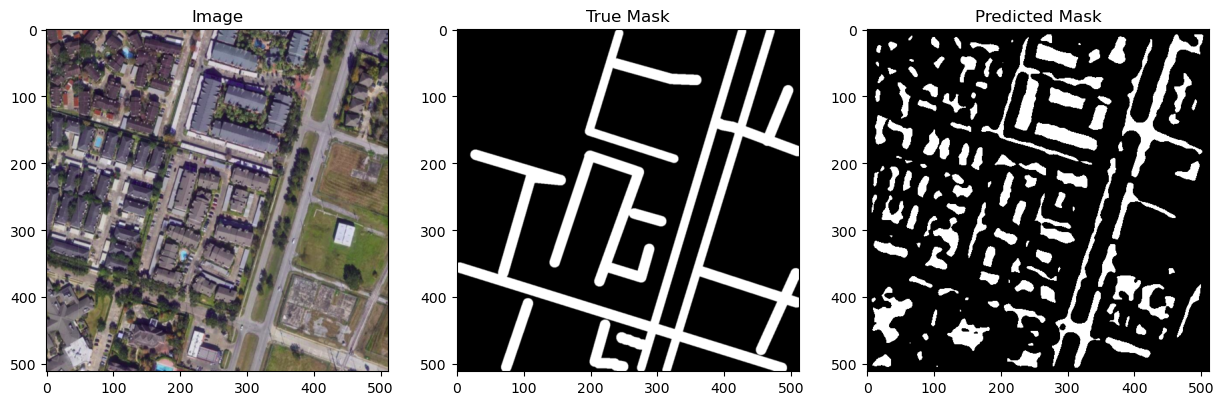

In [15]:
model.eval()
with torch.no_grad():
    img, true_mask = val_dataset[0]
    img = img.unsqueeze(0).to(device)
    pred_mask = torch.sigmoid(model(img))
    pred_mask = (pred_mask > 0.5).float().cpu()[0,0]

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(img[0].permute(1,2,0).cpu())
plt.title("Image")

plt.subplot(1,3,2)
plt.imshow(true_mask[0], cmap="gray")
plt.title("True Mask")

plt.subplot(1,3,3)
plt.imshow(pred_mask, cmap="gray")
plt.title("Predicted Mask")
plt.show()


In [18]:
model = UNet(in_channels=3, num_classes=1).to(device)
MODEL_PATH = "/Users/spoorthivattem/Desktop/checkpoints/unet_epoch_20.pth"
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()


/var/folders/l1/kgd0gw3x2pqg433l5ds6tqnh0000gp/T/ipykernel_8201/84809233.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map

UNet(
  (down_convolution_1): DownSample(
    (conv): DoubleConv(
      (conv_op): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down_convolution_2): DownSample(
    (conv): DoubleConv(
      (conv_op): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down_convolution_3): DownSample(
    (conv): DoubleConv(
      (conv_op): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), paddin

In [19]:
metrics = evaluate_model(model, val_loader, device)

print("\n" + "="*50)
print("FINAL EVALUATION RESULTS")
print("="*50)
print(f"Average IoU: {metrics['IoU']:.4f}")
print(f"Average Dice Score: {metrics['Dice']:.4f}")
print(f"Average Accuracy: {metrics['Accuracy']:.4f}")
print(f"Average Area Error Ratio: {metrics['AreaErrorRatio']:.4f}")
print(f"Average ROC AUC: {metrics['ROC_AUC']:.4f}")
print("="*50)
print("Evaluation completed successfully!")



FINAL EVALUATION RESULTS
Average IoU: 0.2912
Average Dice Score: 0.4409
Average Accuracy: 0.8458
Average Area Error Ratio: 0.3715
Average ROC AUC: -0.8411
Evaluation completed successfully!


/var/folders/l1/kgd0gw3x2pqg433l5ds6tqnh0000gp/T/ipykernel_8201/4204313352.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, 

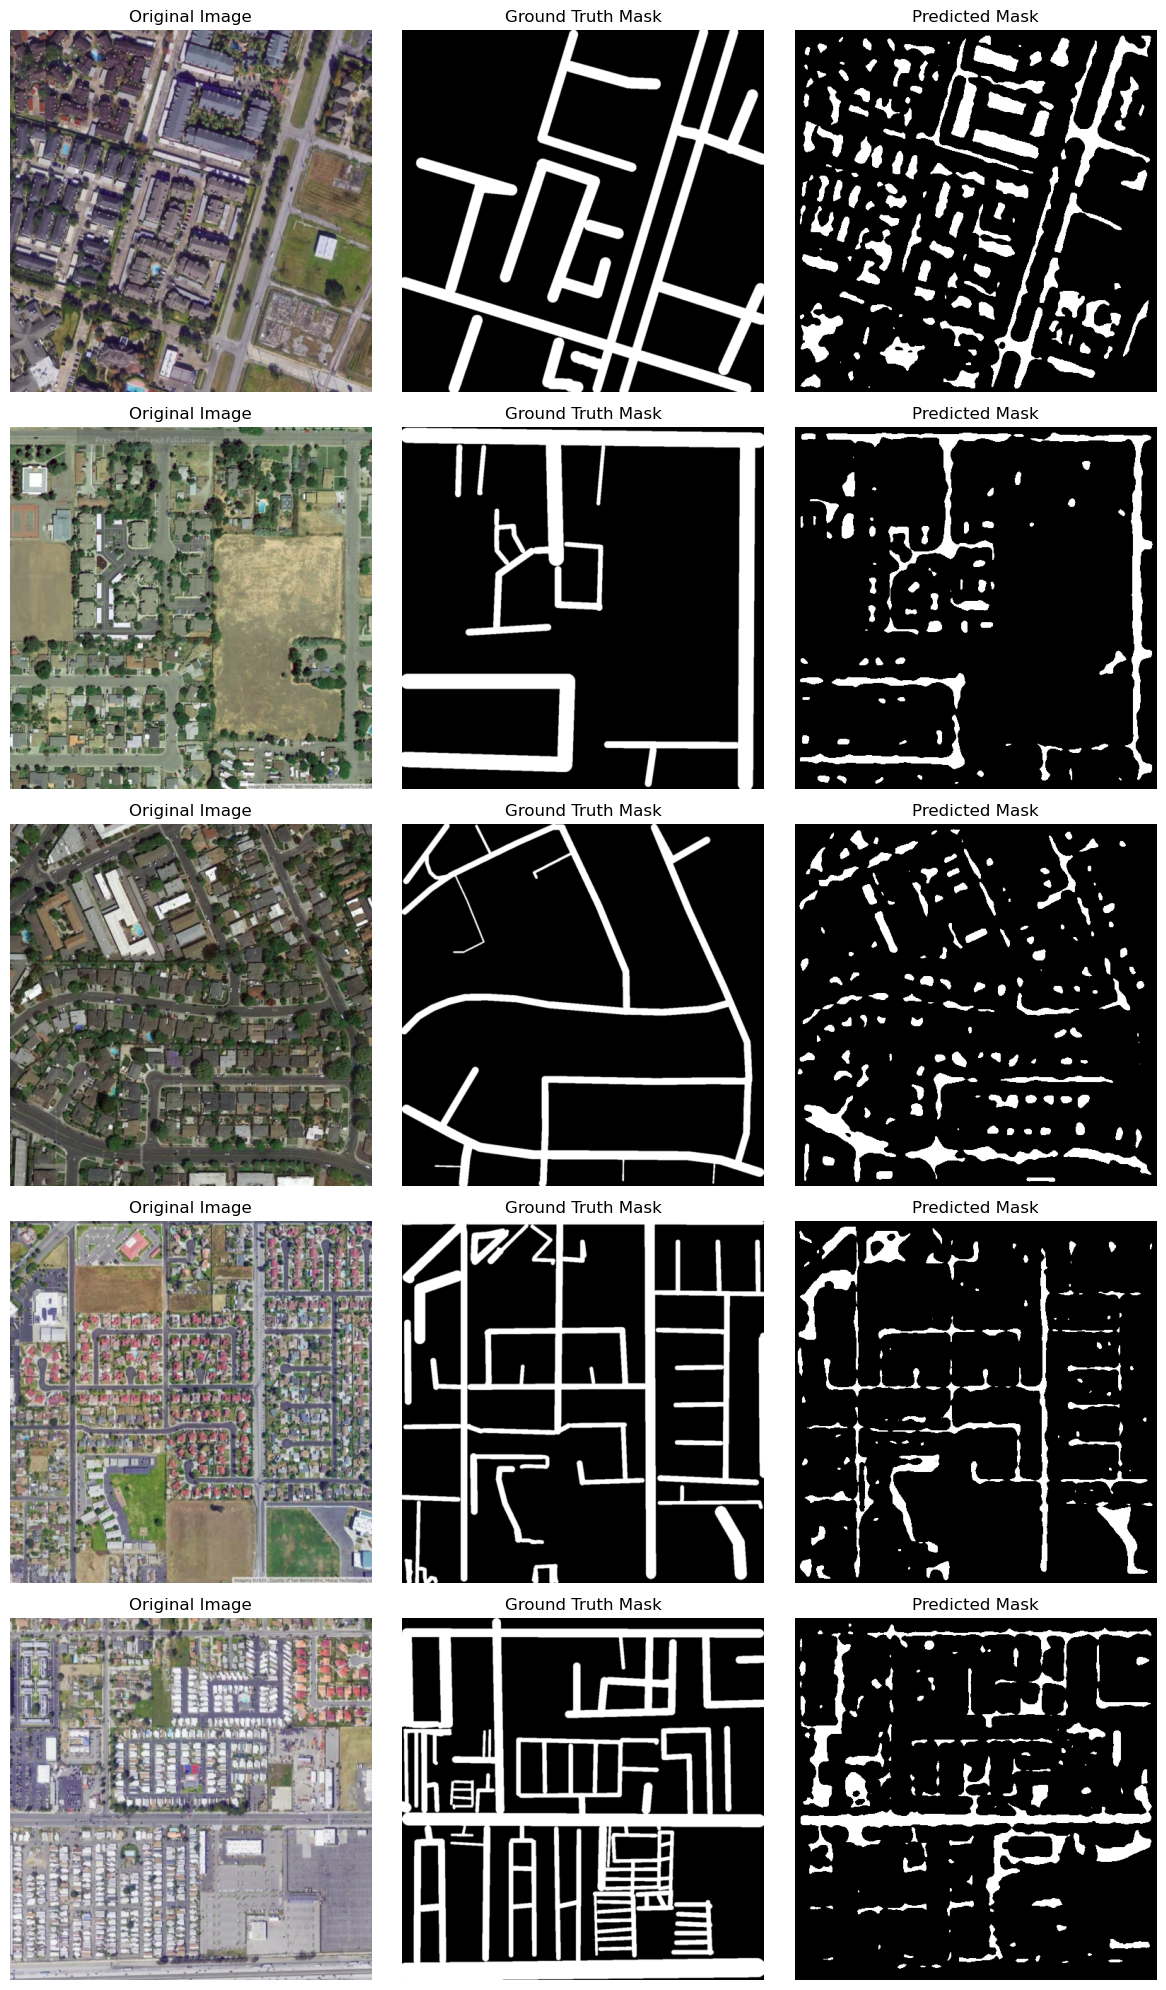

In [20]:
import torch
import matplotlib.pyplot as plt

def visualize_predictions(model, dataset, device, num_samples=5):
    """
    Visualize original image, ground truth mask, and predicted mask.
    """
    model.eval()
    plt.figure(figsize=(12, num_samples * 4))

    for i in range(num_samples):
        # Load image and mask from dataset
        img, true_mask = dataset[i]
        img = img.unsqueeze(0).to(device)  # add batch dimension

        # Predict mask
        with torch.no_grad():
            pred_mask = torch.sigmoid(model(img))
            pred_mask = (pred_mask > 0.5).float()

        # Convert tensors for visualization
        img_np = img.squeeze().permute(1, 2, 0).cpu().numpy()
        true_mask_np = true_mask.squeeze().cpu().numpy()
        pred_mask_np = pred_mask.squeeze().cpu().numpy()

        # Plot original image, ground truth, and prediction
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(img_np)
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(true_mask_np, cmap="gray")
        plt.title("Ground Truth Mask")
        plt.axis("off")

        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(pred_mask_np, cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# -------------------------------
# Load model and visualize results
# -------------------------------
model = UNet(in_channels=3, num_classes=1).to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))

# Visualize 5 random samples from validation dataset
visualize_predictions(model, val_dataset, device, num_samples=5)
